In [1]:
import pandas as pd
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = mlflow.tracking.MlflowClient(tracking_uri="http://localhost:5000")

In [3]:
exp_id = client.get_experiment_by_name("MEK_FAK_ERK").experiment_id
runs = client.search_runs(experiment_ids=exp_id, max_results=3500)
runs_df = pd.DataFrame([{**dict(run.info), **run.data.params, **run.data.metrics} for run in runs])
runs_df = runs_df.drop(columns = ['artifact_uri', 'end_time', 'experiment_id', 'lifecycle_stage', 
                                  'run_uuid', 'start_time', 'status', 'user_id'])

MlflowException: API request to http://localhost:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=MEK_FAK_ERK (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x14972a3e3280>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
runs_df[["param_setting", "CV"]] = [d[47:-1].split("_") for d in runs_df["output_dir"]]
runs_df["n_epochs"] = runs_df["n_epochs"].astype("int")
runs_df["learning_rate"] = runs_df["learning_rate"].astype("float")
runs_df["batch_size"] = runs_df["batch_size"].astype("int")

In [ ]:
run_df[run_df["best_val_loss"].isna()]

In [ ]:
avg_performance = runs_df.groupby("param_setting").mean().sort_values("valid_loss", ascending=True)

In [6]:
avg_performance

,learning_rate,n_epochs,batch_size,train_loss,valid_loss,best_val_loss,val_r2_ERK12,val_r2_FAK,val_r2_MEK12,test_r2_ERK12,test_r2_FAK,test_r2_MEK12,test_mse_ERK12,test_mse_FAK,test_mse_MEK12,test_mse
param_setting,,,,,,,,,,,,,,,,
7,0.200,50.0,10.0,0.024802,0.024599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.200,10.0,10.0,0.025848,0.024645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.005,100.0,10.0,0.022215,0.024826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.010,100.0,300.0,0.024328,0.024867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.200,50.0,300.0,0.025221,0.025208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.200,100.0,1000.0,0.025433,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
17,0.200,100.0,300.0,0.024964,0.025208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,0.200,50.0,1000.0,0.025304,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
15,0.200,10.0,300.0,0.024808,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963


In [8]:
# Find parameter settings without a valid_loss, this means that a checkpoint was never saved
params_with_checkpoints_missing = list(runs_df.loc[runs_df["valid_loss"].isna(), "param_setting"].unique())
params_all_finished = list(runs_df.loc[~runs_df["best_val_loss"].isna(), "param_setting"].unique())


all_finished = runs_df[runs_df["param_setting"].isin(params_all_finished)]
avg_all_finished = all_finished.groupby("param_setting").mean().sort_values("best_val_loss", ascending=True)

all_checkpointed = runs_df[~runs_df["param_setting"].isin(params_with_checkpoints_missing)]
all_checkpointed.loc[all_checkpointed["best_val_loss"].isna(), "best_val_loss"] = all_checkpointed.loc[all_checkpointed["best_val_loss"].isna(), "valid_loss"]
avg_all_checkpointed = all_checkpointed.groupby("param_setting").mean().sort_values("best_val_loss", ascending=True)


/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_17985/1946857741.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_all_finished = all_finished.groupby("param_setting").mean().sort_values("best_val_loss", ascending=True)
/var/folders/54/s3nhktxs0tz7w0f6tsj6pltc0000kp/T/ipykernel_17985/1946857741.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_all_checkpointed = all_checkpointed.groupby("param_setting").mean().sort_values("best_val_loss", ascending=True)


In [20]:
avg_all_checkpointed

,learning_rate,n_epochs,batch_size,train_loss,valid_loss,best_val_loss,val_r2_ERK12,val_r2_FAK,val_r2_MEK12,test_r2_ERK12,test_r2_FAK,test_r2_MEK12,test_mse_ERK12,test_mse_FAK,test_mse_MEK12,test_mse
param_setting,,,,,,,,,,,,,,,,
7,0.200,50.0,10.0,0.024802,0.024599,0.024599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.200,10.0,10.0,0.025848,0.024645,0.024645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.005,100.0,10.0,0.022215,0.024826,0.024826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.005,50.0,1000.0,0.027968,0.025293,0.025293,-4.730235,1.0,1.0,-4.920935,1.0,1.0,0.092817,0.0,0.0,0.030939
8,0.200,100.0,10.0,0.023918,0.025404,0.025404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
avg_all_finished

,learning_rate,n_epochs,batch_size,train_loss,valid_loss,best_val_loss,val_r2_ERK12,val_r2_FAK,val_r2_MEK12,test_r2_ERK12,test_r2_FAK,test_r2_MEK12,test_mse_ERK12,test_mse_FAK,test_mse_MEK12,test_mse
param_setting,,,,,,,,,,,,,,,,
26,0.200,100.0,1000.0,0.025433,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
25,0.200,50.0,1000.0,0.025304,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
15,0.200,10.0,300.0,0.024808,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
20,0.010,100.0,1000.0,0.025450,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
19,0.010,50.0,1000.0,0.023754,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
12,0.005,10.0,300.0,0.025529,0.025208,0.025208,-4.916886,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
24,0.200,10.0,1000.0,0.024243,0.025208,0.025208,-4.916886,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
18,0.010,10.0,1000.0,0.025483,0.025208,0.025208,-4.916889,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
22,0.005,50.0,1000.0,0.027968,0.025293,0.025293,-4.730235,1.0,1.0,-4.920935,1.0,1.0,0.092817,0.0,0.0,0.030939


In [22]:
avg_performance

,learning_rate,n_epochs,batch_size,train_loss,valid_loss,best_val_loss,val_r2_ERK12,val_r2_FAK,val_r2_MEK12,test_r2_ERK12,test_r2_FAK,test_r2_MEK12,test_mse_ERK12,test_mse_FAK,test_mse_MEK12,test_mse
param_setting,,,,,,,,,,,,,,,,
7,0.200,50.0,10.0,0.024802,0.024599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.200,10.0,10.0,0.025848,0.024645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.005,100.0,10.0,0.022215,0.024826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0.010,100.0,300.0,0.024328,0.024867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0.200,50.0,300.0,0.025221,0.025208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.200,100.0,1000.0,0.025433,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
17,0.200,100.0,300.0,0.024964,0.025208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,0.200,50.0,1000.0,0.025304,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963
15,0.200,10.0,300.0,0.024808,0.025208,0.025208,-4.916885,1.0,1.0,-4.930752,1.0,1.0,0.092890,0.0,0.0,0.030963


<AxesSubplot: xlabel='learning_rate', ylabel='best_val_loss'>

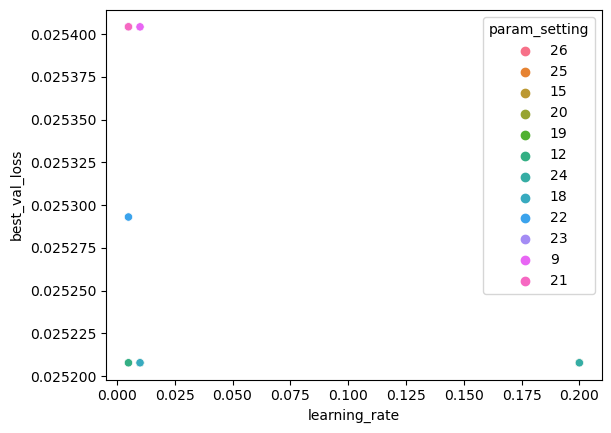

In [16]:
sns.scatterplot(data=avg_all_finished, x="learning_rate", y="best_val_loss", hue="param_setting")

<AxesSubplot: xlabel='batch_size', ylabel='best_val_loss'>

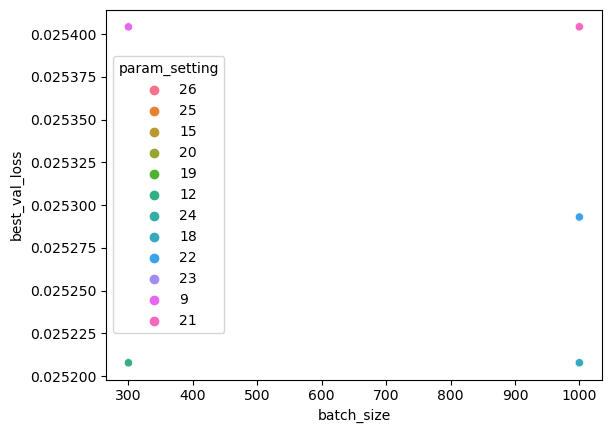

In [18]:
sns.scatterplot(data=avg_all_finished, x="batch_size", y="best_val_loss", hue="param_setting")


<AxesSubplot: xlabel='n_epochs', ylabel='best_val_loss'>

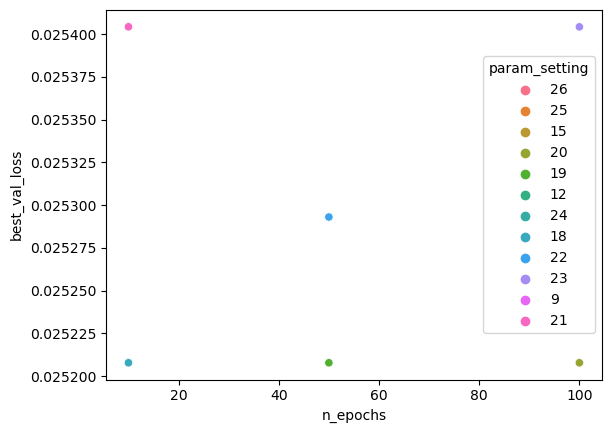

In [17]:
sns.scatterplot(data=avg_all_finished, x="n_epochs", y="best_val_loss", hue="param_setting")